# Google Colab Setup

In [ ]:
#@title << Setup Google Colab by running this cell {display-mode: "form"}
import sys
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/epfl-exts/amld24-applications-ML-workshop.git
        
    # Copy files required to run the code
    !cp -r "amld24-applications-ML-workshop/text_classification_case_study/data" "amld24-applications-ML-workshop/text_classification_case_study/tools.py" .
    
    # Install packages via pip
    !pip install -r "amld24-applications-ML-workshop/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

# Text classification :: Overview

## Task 

We want to build a Spam detector which, given examples of spam emails (e.g. flagged by users) and examples of regular (non-spam, also called "ham") emails, learns how to flag new unseen emails as spam or non-spam.

## Data

We will use the [SpamAssassin](https://spamassassin.apache.org/) public email corpus. This dataset contains ~6'000 labeled emails with a ~30% spam ratio. If you want to learn more about this dataset, check [this](https://spamassassin.apache.org/old/publiccorpus/). (*Note: Datasets of text are called corpora and samples are called documents.*) 

The dataset has been downloaded for you and is available in the *data* folder.

## Notebook overview

* Load the data
* Text preprocessing
* Data exploration
* Feature extraction
* Build a spam detector
* What did our model learn? Error analysis

# Text classification :: Spam detection


## Load the data

In [1]:
# Load libraries and helper functions
import tools

In [2]:
# Load the data
df = tools.load_data()

Data loaded.
Data size: (5832, 2)


Let's check the number of samples per class in the data.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: label, dtype: float64




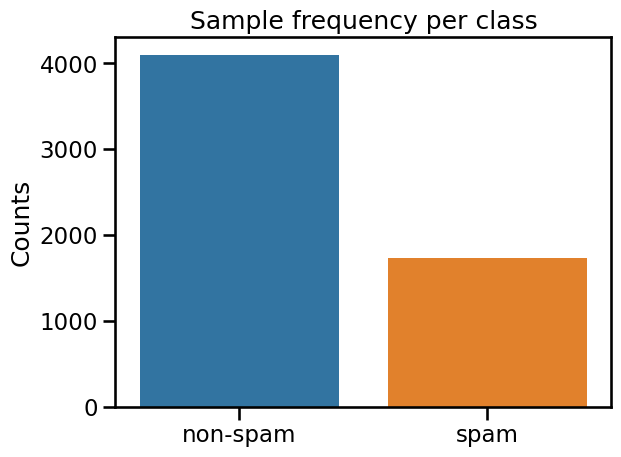

In [3]:
tools.plot_class_frequency(df)

Now, let's have a look at a few rows from the dataset.

***Note:*** The *label* is 0 for *non-spam* and 1 for *spam*.

In [4]:
# If you rerun this cell then you get a different set of samples displayed
df.sample(3)

,label,text
892,1,"Obtain a prosperous future, money earning power, and the admiration of all. Degrees from Prestigious Accredited Universities based on your present knowledge and life experience. CALL NOW to receive your diploma within days!!! 1 425 790 3463 No required tests, classes, books, or interviews. Bachelors, masters, MBA, and doctorate (PhD) diplomas available in the field of your choice. No one is turned down. Confidentiality assured. CALL NOW to receive your diploma within days!!! 1 425 790 3463 Call 24 hours a day, 7 days a week, including Sundays and holidays. 231175433222211111111"
4127,0,"On Thursday 29 August 2002 16:39 CET Mike Burger wrote: > >[...] > > re-check I find it immediately: > > :0fw > > * < 250000 > > | spamassassin -P > > > > Works perfectly now. Sorry for being such a pest! ;-) > >[...] > > I'm using SA via spamc/spamd, and a global /etc/procmail file. I'm > wondering if this would also work in that fashion. spamc will skip every file bigger than 250k on it's own. It's got the command line switch -s to change this value. But it doesn't hurt of course to use the procmail limit. Malte -- -- Coding is art. -- ------------------------------------------------------- This sf.net email is sponsored by:ThinkGeek Welcome to geek heaven. http://thinkgeek.com/sf _______________________________________________ Spamassassin-talk mailing list Spamassassin-talk@lists.sourceforge.net https://lists.sourceforge.net/lists/listinfo/spamassassin-talk"
2776,0,"[Guido] > There seem to be two ""drivers"" for the classifier now: Neale Pickett's > hammie.py, and the original GBayes.py. According to the README.txt, > GBayes.py hasn't been kept up to date. It seemed that way to me when I ripped the classifier out of it -- I don't think anyone has touched it after. > Is there anything in there that isn't covered by hammie.py? Someone else will have to answer that (I don't use GBayes or hammie, at least not yet). > About the only useful feature of GBayes.py that hammie.py doesn't (yet) > copy is -u, which calculates spamness for an entire mailbox. This > feature can easily be copied into hammie.py. That's been done now, right? > (GBayes.py also has a large collection of tokenizers; but timtoken.py > rules, so I'm not sure how interesting that is now.) Those tokenizers are truly trivial to rewrite from scratch if they're interesting. The tiny spam/ham collections in GBayes are also worthless now. The ""self test"" feature didn't do anything except print its results; Tester.py since became doctest'ed and verifies that some basic machinery actually delivers what it's supposed to deliver. > Therefore I propose to nuke GBayes.py, after adding a -u feature. +1 here. > Anyone against?"


## Text preprocessing

Good text preprocessing is an essential part of every NLP project!

Our goal here is to build a model that distinguishes non-spam from spam. The idea here is to "clean" and "standardize" raw text before feeding it to our machine learning model. We need to keep as many "informative" words as possible, while discarding the "uniformative" ones. Removing unnecessary content, i.e. the "noise", from our texts will help to improve the accuracy of our models.

<div class="alert alert-success">
<h3>Questions</h3>
    
Take a few minutes to look at the raw text.
    
__Q1.__ Which parts of the text do you think should be removed to make it readable?
    
__Q2.__ How could the parts that we have just removed for text cleaning still be useful for the distinction of spam and non-spam?
</div>

### Answers

__Q1.__ Here are some suggestions of what could be removed or changed in order to clean the text:

* HTML tags 
* URLs
* E-mail addresses
* Punctuation marks, digits (e.g. 2002, 1.1, ...)
* Multiple whitespaces
* Case conversion (e.g. Dog vs dog, ...)
* English STOPWORDS (e.g. a, is, my, i, all, and, by...)
* ...

__Q2.__ The precise text within HTML tags, URLs, or email addresses will differ so much between our samples that it is unlikely to be helpful to distinguish spam from non-spam. However, the number of occurrences of HTML tags, URLs, etc. within a text might be useful for this distinction. Similarly, the length of the emails and the frequency of punctuation marks or upper case letters may also give us clues as to whether we are dealing with spam or not.


The *clean_corpus* function below will take care of the parts raised by Question 1.

For the ideas from Question 2 we will create new features and investigate their effects in the subsection **What about "spammish" signatures?**. 

In [5]:
df = tools.clean_corpus(df)

print("Data cleaned")

Data cleaned


Let's have a look at a few "cleaned" examples.

In [6]:
tools.show_clean_text(df)


Original document:

<html> <head> <meta http-equiv=3D"Content-Type" content=3D"text/html; charset=3Diso-8859-1"> </head>
<body bgcolor=3D"#FFFFFF"> <table width=3D"58%" height=3D"257"> <tr valign=3D"top"> <td
height=3D"253"> <p><font size=3D"3"><b>Fortunes are literally being made in this new=
marketplace.</b></font> </p> <p>O<font size=3D"3"></font><font size=3D"3">ver <b>$9 Billion</b> i= n
merchandise was sold on <b>eBay</b> in 2001 by people just like you - <u>right= from their
homes</u>! </font></p> <p><font size=3D"3">Now you too can learn the secrets of <b>successf= ul
selling </b>on<b> eBay</b> and <b>make a staggering income</b> from the co= mfort of <b>your own
home</b>. If you are <b>motivated</b>, capable of h= aving an<b> open mind</b>, and can follow
simple directions, then <a hre= f=3D"http://www.nationalbizcorp.com/ebooks">visit us here</a>. If
server busy - <a href=3D"http://www.generaledu.com= /ebooks">alternate.</a></font></p> <p><font
size=3D"2">You received this o

## Data Exploration :: What makes spam distinct?

### Frequent words

Which words distinguish spam from non-spam? Can we  identify the words in a text that are the most informative about its topic?

Let's find the 10 most frequent words in spam and non-spam and compare them.

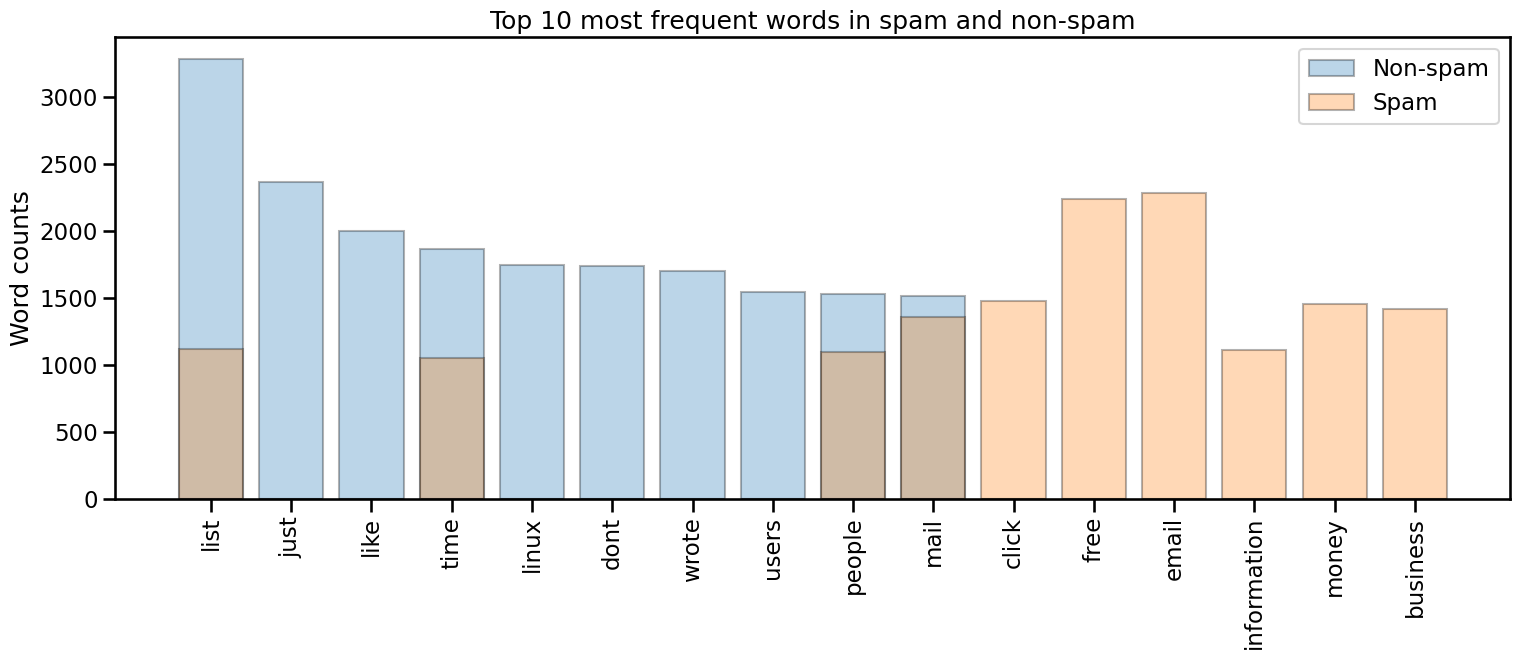

In [7]:
tools.plot_most_common_words(df=df, N=10)

<div class="alert alert-success">
<h3>Questions</h3>
    
__Q1.__ Which of the top 10 most frequent "spammish" words are unique to that class?

__Q2.__ Which of the top 10 most frequent "non-spammish" words are unique to that class?
     
__Q3.__ For the words that occur in both lists, which ones are likely still useful for distinguishing the classes?
    
__Q4.__ Which ones are likely not?
    
    
</div>

### Answers

__Q1.__ **Frequent "spammish" words**: 

* free
* email
* click
* business
* money

__Q2.__ **Frequent "non-spammish" words**:
* just
* like
* linux
* wrote
* users  

__Q3.__ **Occur in both top 10 but could be useful for distinctions**:
* list
* time

__Q4.__ **Occur in both top 10 but are unlikely to be useful**:
* people
* mail

<div class="alert alert-success">
<h3>Task 1</h3>
    
Change `N=10` to `N=30` and compare the outcome.
</div>

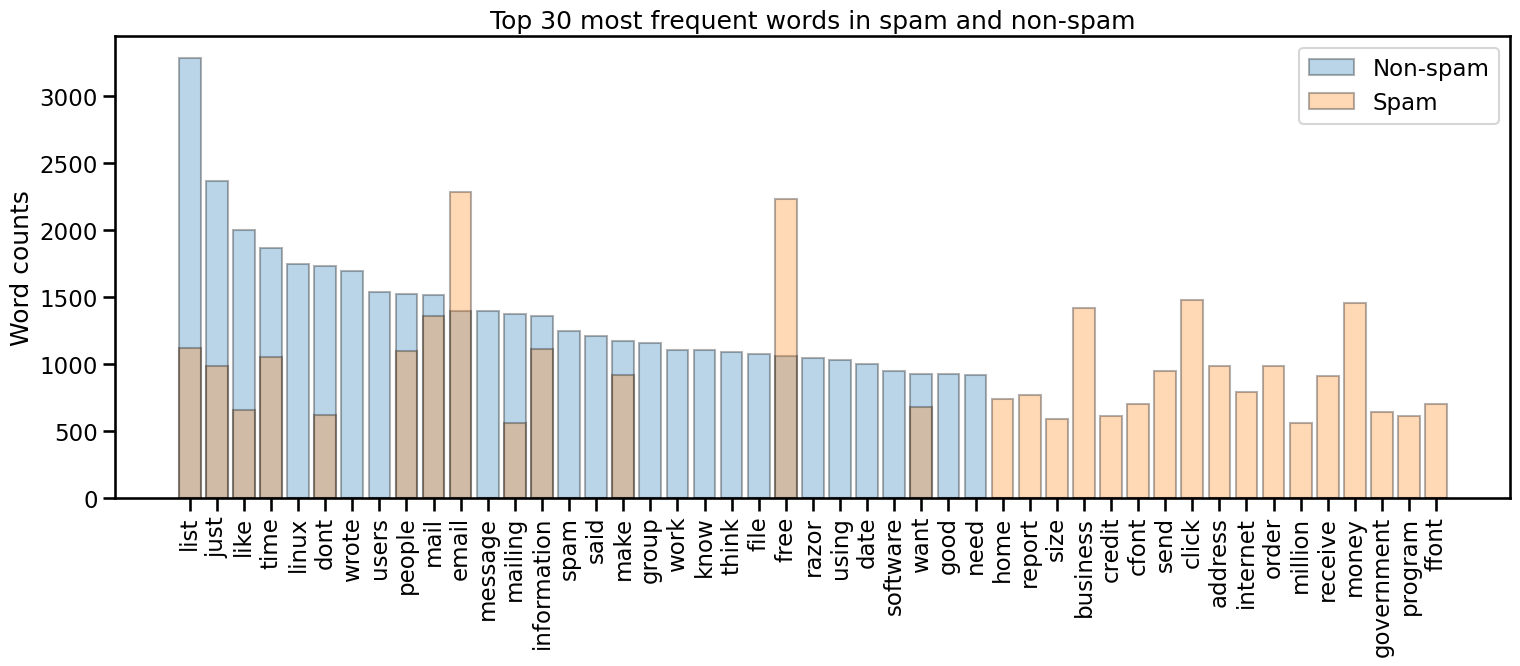

In [14]:
tools.plot_most_common_words(df=df, N=30)

### Observation

As we use more top words we get more overlap between the classes.  
However words like _email_ or _free_ are still mch more frequent in the **spam** class 

### What about "spammish" signatures?

* Do spams contain more HTML tags? 
* Does non-spam contain more URLs and E-mail adresses? 
* Are spams mails longer than non-spam? 
* ...

Let's find out!

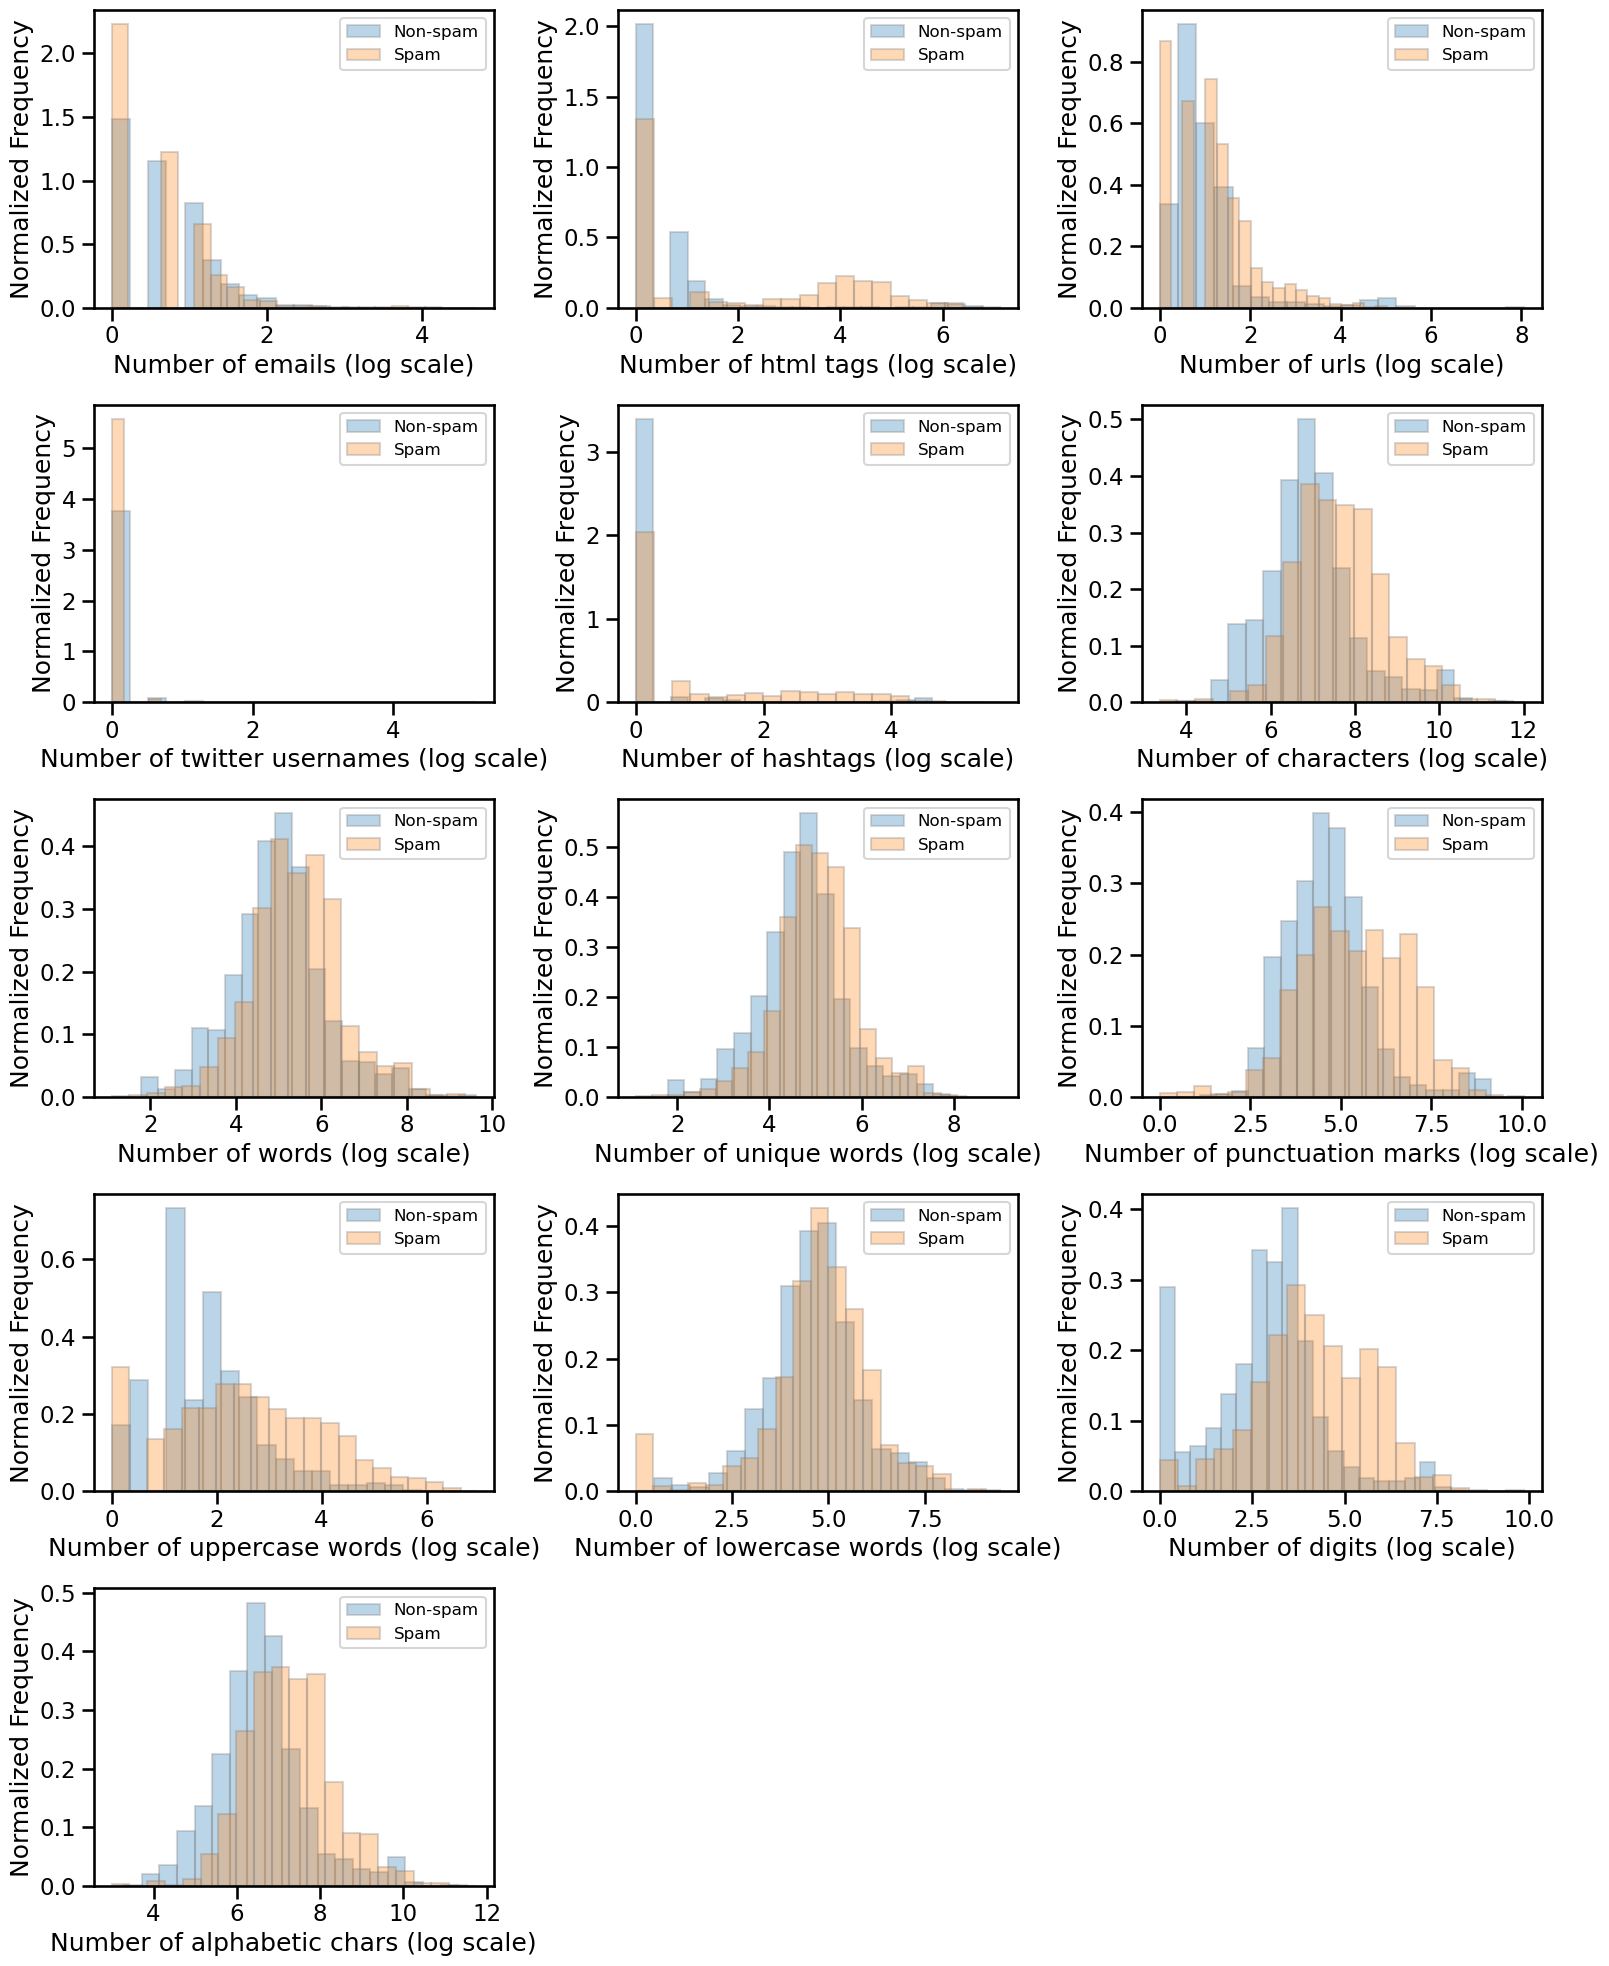

In [15]:
features = tools.get_features(df=df)

## Feature engineering :: Extracting features from text

Computers don't understand natural language. So, how do we represent text?

One of the simplest but effective and commonly used models to represent text for machine learning is the ***Bag of Words*** model ([online documentation](https://en.wikipedia.org/wiki/Bag-of-words_model)). When using this model, we discard most of the structure of the input text (word order, chapters, paragraphs, sentences and formating) and only count how often each word appears in each text. Discarding the structure and counting only word occurencies leads to the mental image of representing text as a "bag".  

**Example:** Let our toy corpus contain four documents.

$ corpus = ['I\;enjoy\;paragliding.',  $  
$\hspace{2cm}'I\;like\;NLP.',$  
$\hspace{2cm}'I\;like\;deep\;learning.',$  
$\hspace{2cm}'O\;Captain!\;my\;Captain!']$ 

In [16]:
tools.show_bag_of_words_vector()

,captain,deep,enjoy,i,learning,like,my,nlp,o,paragliding
Text,,,,,,,,,,
I enjoy paragliding.,0,0,1,1,0,0,0,0,0,1
I like NLP.,0,0,0,1,0,1,0,1,0,0
I like deep learning.,0,1,0,1,1,1,0,0,0,0
O Captain! my Captain!,2,0,0,0,0,0,1,0,1,0


Bag of Words has converted all documents into numeric vectors. Each column represents a word from the corpus and each row one of the four documents. The value in each cell represents the number of times that word appears in a specific document. For example, the fourth document has the word `captain` occuring twice and the words `my` and `O` occuring once.

## Build a spam detector

In the previous section, we saw how to perform text preprocessing and feature extraction from text. We are now ready to build our machine learning model for detecting spams. We will use a Logistic Regression classifier ([online documentation](https://en.wikipedia.org/wiki/Logistic_regression)).

First, split the data into two sets: the `train` set and the `test` set. We will then use the train set to `fit` our model. We will use 5-fold cross-validation. So the validation sets are automatically created internally. The test set will be used to `evaluate` the performance of our model. 

### Baseline

70.3% of samples are non-spam. This naive baseline model would reach 70+% for doing very little.

### Spam classification

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

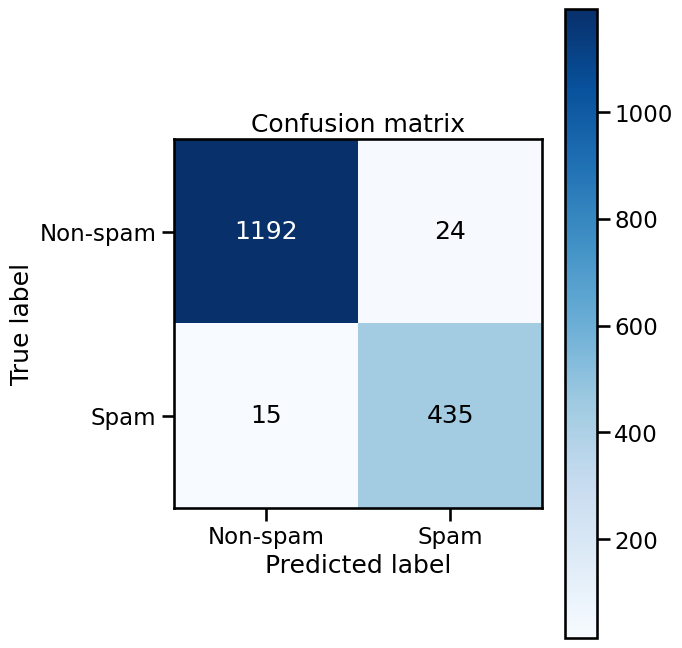

In [17]:
# Train/test splitting
df_train, df_test = tools.train_test_split_(df)

# Fit model on the train data
model = tools.fit_model(df_train)

# Print predictions on test set
tools.plot_confusion_matrix(df_test, model)

**Confusion matrices**  

Confusion matrices are a nice way of evaluating the performance of models for classification models. Rows correspond to the true classes and the columns to the predicted classes. Entries on the main diagonal of the confusion matrix correspond to correct predictions while the other cells tell us how many mistakes made our model ([online documentation]((https://en.wikipedia.org/wiki/Confusion_matrix))).

* The first row represents non-spam mails: 1'187 were correctly classified as 'non-spam', while 29 (~2,3%) were misclassified as 'spam'.
* The second row represents spam mails: 437 were correctly classified as 'spam', while 13 (~2,8%) were misclassified as 'non-spam'.

Our model did quite well!

### What did our model learn from the data?

Our logistic regression model has learned which words are the most indicative of non-spam and which words are the most indicative of spam. The positive coefficients on the right correspond to words that, according to the model, are indicative of spam. The negative coefficients on the left correspond to words that, according to the model, are indicative of non-spam.

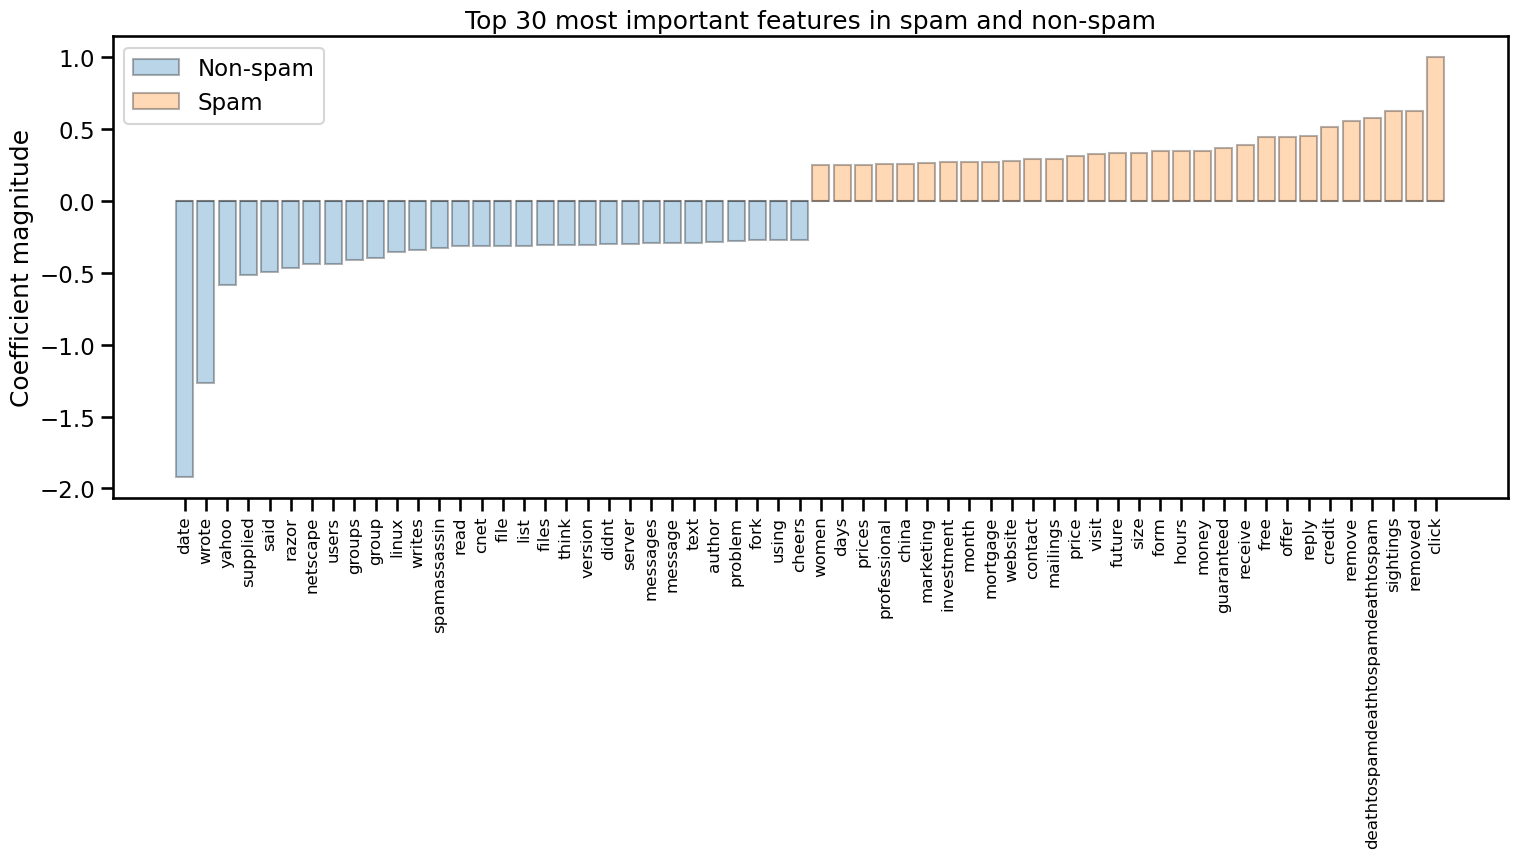

In [18]:
tools.visualize_coefficients(model, n_top_features=30)

<div class="alert alert-success">
<h3>Questions</h3>
    
__Q1.__ According to the model which words are strong indicators of non-spam, respectively spam? 
    
__Q2.__ Do they overlap with the results of our analysis?<br>
    
</div>

### Answers

__Q1.__ According to the model, words such as "date", "wrote", "yahoo", "said", "linux", "author", ... are strong indicators of non-spam.  

Words such as "click", "credit", "remove", "free", "offer", "money" ... indicate spam.

__Q2.__ Indeed some do. For example we had identified "wrote", "said" and "linux" as potential indicators of non-spam ealier. Similarly "click", "credit", "free", and "money" suggested spam.

### Error analysis :: Where does our model fail?

We will now analyze the misclassified mails in order to get some insights on where the model failed to make correct predictions. The *error_analysis* function below will show us the top features responsible for the model making a decision of prediction whether the mail is spam or non-spam.

Document index: 16 


Original Text
<html><body> <center> <font face="arial"><b>Talk on Tele with locals in your area who want to meet
for real encounters. No pre recorded bull this is the real deal. <p> US residents: the 9<!--dads
tools-->00-370-54<!--starter-->65 or 8<!--ender-->88-400-1<!--end-->919. - 99<!--hi hi --> cents /
min <p> For CA callers try our special California line, California is so popular we had to create a
seperate system just for them <p> : 1-<!--moms-->9<!--low-->00-505-7575. <p> must be 18<!--none-->+
be careful when making sexual dates and meetings. Cali 9<!--polic cars-->00# is $1.99 per min
</html> 211075433222 


Cleaned text
talk tele locals area want meet real encounters recorded bull real deal residents cents callers
special california line california popular create seperate just careful making sexual dates meetings
cali 


Actual class:     Spam
Predicted class:  Non-spam 


Predicted probabilities

Non-spam:   0.5239
Spam:       0.4761



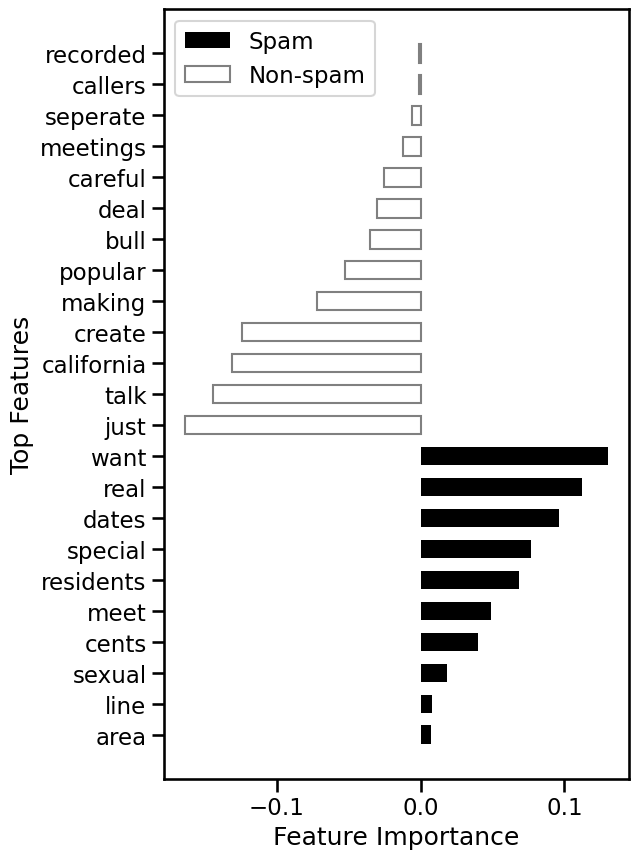

In [19]:
tools.error_analysis(df_test, model, doc_nbr=16)

<div class="alert alert-success">
<h3>Task 2</h3>
    
Let's change the `doc_nbr`.
</div>